# Описание задачи:
Целью данной работы является разработка модели машинного обучения для предсказания стоимости жилья в различных районах Калифорнии на основе разнообразных признаков.

Для этого используется датасет fetch_california_housing, который содержит информацию о медианной стоимости домов в блоках населения в Калифорнии.

### Этапы работы:


#### Обзор данных:

        Проведен анализ данных с использованием визуализаций для понимания распределений признаков и взаимосвязей между ними.

#### Выбор и создание признаков:

        Выбор наиболее важных признаков для включения в модель.
        Возможно, создание новых признаков на основе имеющихся данных.

#### Обработка данных:

        Произведена очистка данных от пропущенных значений и выбросов.
        Произведено масштабирование признаков для более эффективного обучения модели.

#### Выбор модели:

        Выбор регрессионной модели для предсказания стоимости жилья.
        Подгонка параметров модели с использованием кросс-валидации.

#### Оценка модели:
 
        Использование метрик, таких как среднеквадратичная ошибка (MSE) или коэффициент детерминации (R2), для оценки качества модели.

In [338]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


from scipy.stats import randint
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [339]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
data = california_housing.frame
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


# Обзор данных:

### Проверка на дубликаты

In [340]:
data[data.duplicated()]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal


### Количество отсутствующих данных

In [341]:
data.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

### Проверка на выбросы и неадекватные значения

#### странные значения есть в:

        кол. комнат - 141
        кол. спальнь - 34
        население - 35682 (в описании данных было сказано, что в среднем в блоке живут от 600 до 3000 человек)
        кол. человек в семье - 1243

In [342]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population", "MedHouseVal"]
# california_housing.frame[features_of_interest]
data.drop(columns=["Latitude", "Longitude"]).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,5.000010


#### На графиках мы можем наблюдать:

        1.MedInc - небольшое количество зарплат в 15к, но в целом всё выглядит адекватно
        2.HouseAge - большое количество домов возрастом в 52
        3.Как я и говорил большие выбросы находятся в: "AveRooms", "AveBedrms", "AveOccup", "Population"
        4.Все дома которые стоят больше 5 принимают значение 5

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'MedHouseVal'}>]], dtype=object)

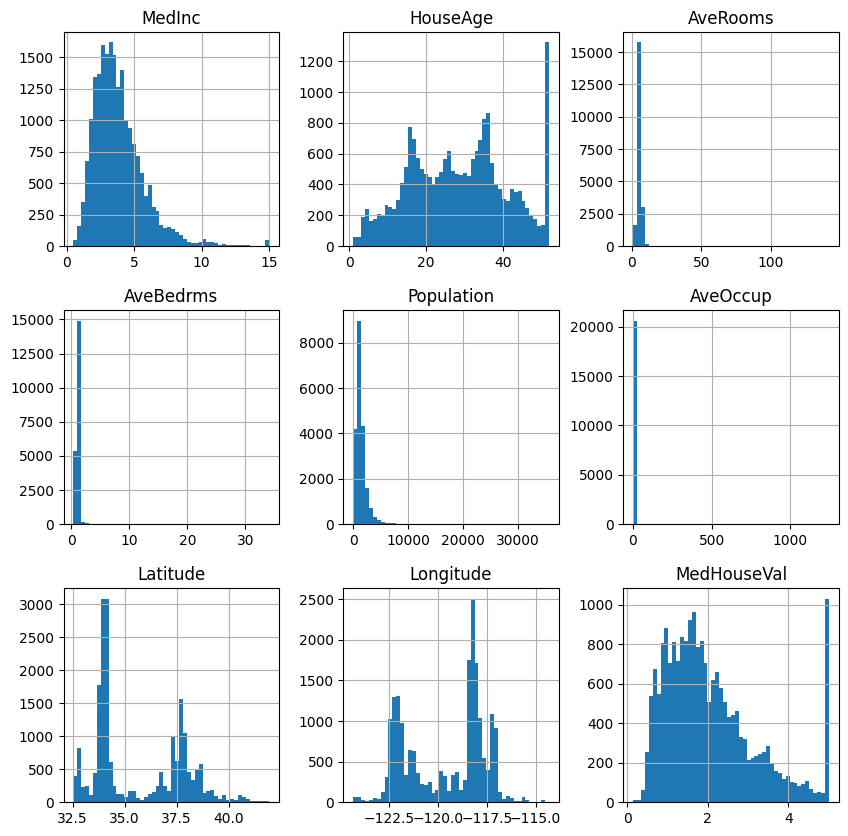

In [343]:
data.hist(bins=50, figsize=(10, 10))

#### проверим зависимость расположения и цены

        На карте мы можем 3 области с большими ценами на дома
        
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


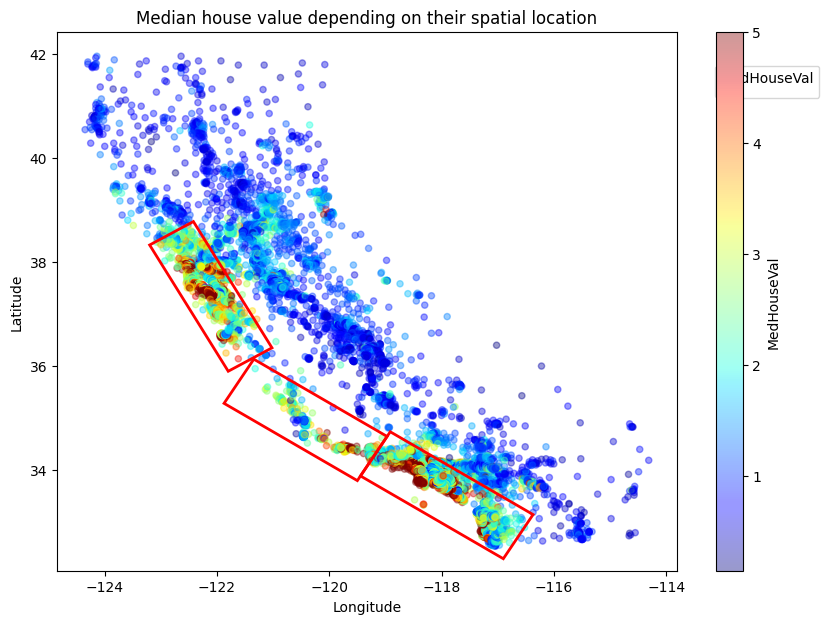

In [344]:
data.plot(kind='scatter', x="Longitude", y="Latitude", alpha=0.4,
             figsize=(10,7),
             c="MedHouseVal", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

x1 = -121.8
y1 = 35.9
width1 = 0.9
height1 = 2.8
angle1 = 30

rectangle = plt.Rectangle((x1, y1), width1, height1, fill=None, edgecolor='red', linewidth=2, angle=angle1)
plt.gca().add_patch(rectangle)

x2 = -119.5
y2 = 33.8
width2 = 1
height2 = 2.8
angle2 = 58

rectangle = plt.Rectangle((x2, y2), width2, height2, fill=None, edgecolor='red', linewidth=2, angle=angle2)
plt.gca().add_patch(rectangle)

x3 = -116.9
y3 = 32.3
width3 = 1
height3 = 3
angle3 = 58

rectangle = plt.Rectangle((x3, y3), width3, height3, fill=None, edgecolor='red', linewidth=2, angle=angle3)
plt.gca().add_patch(rectangle)

# Добавляем легенду и заголовок
plt.legend(title='MedHouseVal', bbox_to_anchor=(1.05, 0.95), loc='upper left')
plt.title('Median house value depending on their spatial location')
plt.show()



# Выбор и создание признаков:

Предлогаю добавить в наш dataset новый признак.

rich_area

In [345]:
def point_inside_rotated_rectangle(x, y, x_rect, y_rect, width, height, angle):
    x_diff = x - x_rect
    y_diff = y - y_rect
    rotated_x = x_diff * np.cos(np.radians(angle)) + y_diff * np.sin(np.radians(angle))
    rotated_y = -x_diff * np.sin(np.radians(angle)) + y_diff * np.cos(np.radians(angle))

    
    if 0 <= rotated_x <= width and 0 <= rotated_y <= height:
        return True
    else:
        return False

# можем проверить работу нашего скрипта подставив значения
point_to_check_x = -121.09
point_to_check_y = 39.48


result1 = point_inside_rotated_rectangle(point_to_check_x, point_to_check_y, x1, y1, width1, height1, angle1)
print(f"Точка внутри прямоугольника 1: {result1}")


result2 = point_inside_rotated_rectangle(point_to_check_x, point_to_check_y, x2, y2, width2, height2, angle2)
print(f"Точка внутри прямоугольника 2: {result2}")


result3 = point_inside_rotated_rectangle(point_to_check_x, point_to_check_y, x3, y3, width3, height3, angle3)
print(f"Точка внутри прямоугольника 3: {result3}")

Точка внутри прямоугольника 1: False
Точка внутри прямоугольника 2: False
Точка внутри прямоугольника 3: False


In [346]:
data[['Longitude', 'Latitude']]

,Longitude,Latitude
0,-122.23,37.88
1,-122.22,37.86
2,-122.24,37.85
3,-122.25,37.85
4,-122.25,37.85
...,...,...
20635,-121.09,39.48
20636,-121.21,39.49
20637,-121.22,39.43
20638,-121.32,39.43


In [347]:
def check(x, y):
    result1 = point_inside_rotated_rectangle(x, y, x1, y1, width1, height1, angle1)
    result2 = point_inside_rotated_rectangle(x, y, x2, y2, width2, height2, angle2)
    result3 = point_inside_rotated_rectangle(x, y, x3, y3, width3, height3, angle3)
    if  result1 or result2 or result3:
        return 1
    else:
        return 0

data["rich_area"] = [check(x, y) for x, y in data[['Longitude', 'Latitude']].values]
data.rich_area.unique()

array([1, 0], dtype=int64)

In [348]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,rich_area
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,0


Оценка зависимости добавленного признака к целевой переменной

Как мы видим у нового признака с целевой переменной кореляция равна 52%

In [349]:
matrix = data.corr()
matrix['MedHouseVal'].sort_values(ascending=False)


MedHouseVal    1.000000
MedInc         0.688075
rich_area      0.528527
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

# Обработка данных:

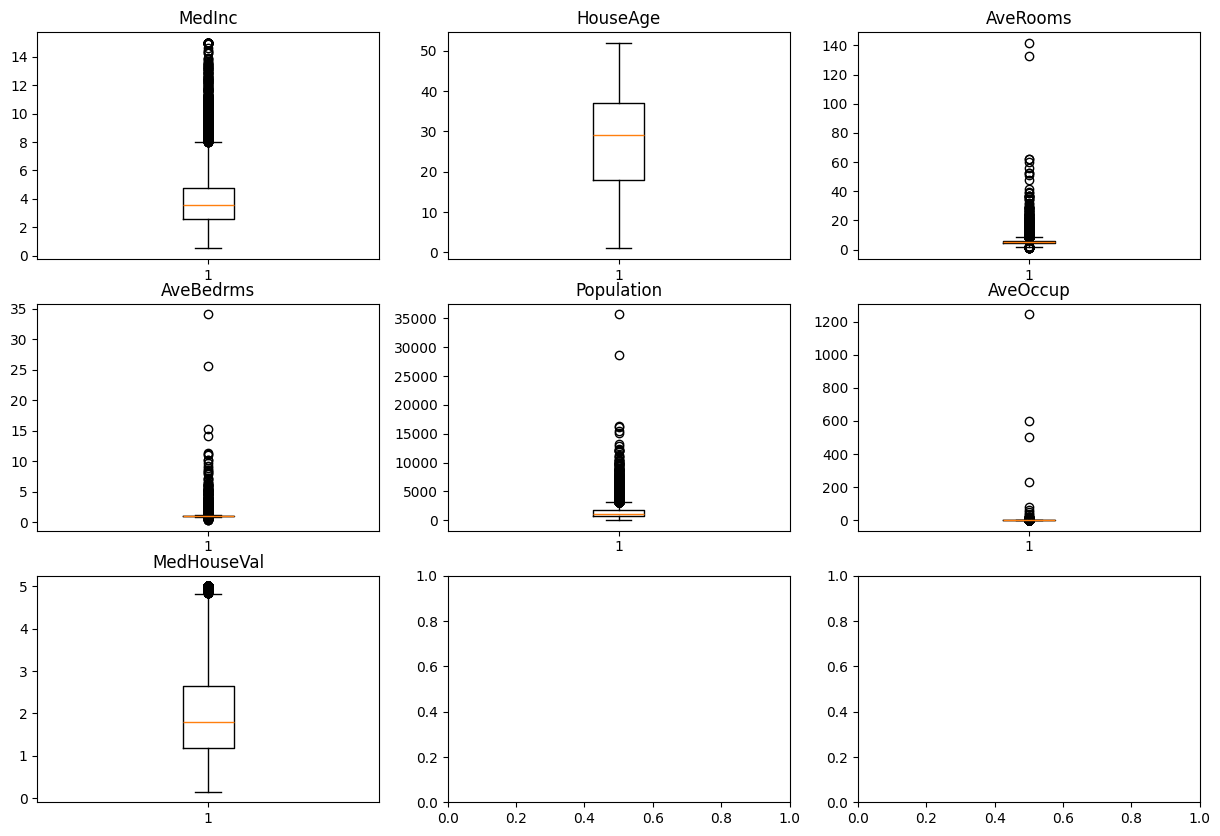

In [350]:
import matplotlib.pyplot as plt


y = data

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))


ax[0,0].boxplot(y.iloc[:, 0])
ax[0,0].set_title("MedInc") 
        
ax[0,1].boxplot(y.iloc[:, 1])
ax[0,1].set_title("HouseAge") 

ax[0,2].boxplot(y.iloc[:, 2])
ax[0,2].set_title("AveRooms") 

ax[1,0].boxplot(y.iloc[:, 3])
ax[1,0].set_title("AveBedrms") 

ax[1,1].boxplot(y.iloc[:, 4])
ax[1,1].set_title("Population") 

ax[1,2].boxplot(y.iloc[:, 5])
ax[1,2].set_title("AveOccup") 

ax[2,0].boxplot(y.iloc[:, 8])
ax[2,0].set_title("MedHouseVal") 

plt.show()

#### С помощью импутации данных приведём данные в нормальный вид (KNNImputer)

        Заменяю неадекватные значения на NaN и далее импутирую их на основе метода K-близжайших соседей

In [351]:
data.loc[(data.Population > 4000), 'Population'] = np.NaN
data.loc[(data.AveOccup > 6), 'AveOccup'] = np.NaN
data.loc[(data.AveRooms > 10), 'AveRooms'] = np.NaN
data.loc[(data.AveBedrms > 4), 'AveBedrms'] = np.NaN
data.loc[(data.AveBedrms < 1), 'AveBedrms'] = 1
# data.loc[(data.MedHouseVal >= 5), 'MedHouseVal'] = np.NaN

процесс импутаци

In [353]:
df_num = data.select_dtypes('float64')
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputer.fit(df_num)
rich_area = data['rich_area'].values
print(rich_area)
data = pd.DataFrame(imputer.transform(df_num), index=df_num.index, columns=df_num.columns)
data['rich_area'] = rich_area
# print(data.isnull().sum())
data

[1 1 1 ... 0 0 0]


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,rich_area
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,1.000000,2401.0,2.109842,37.86,-122.22,3.585,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,0


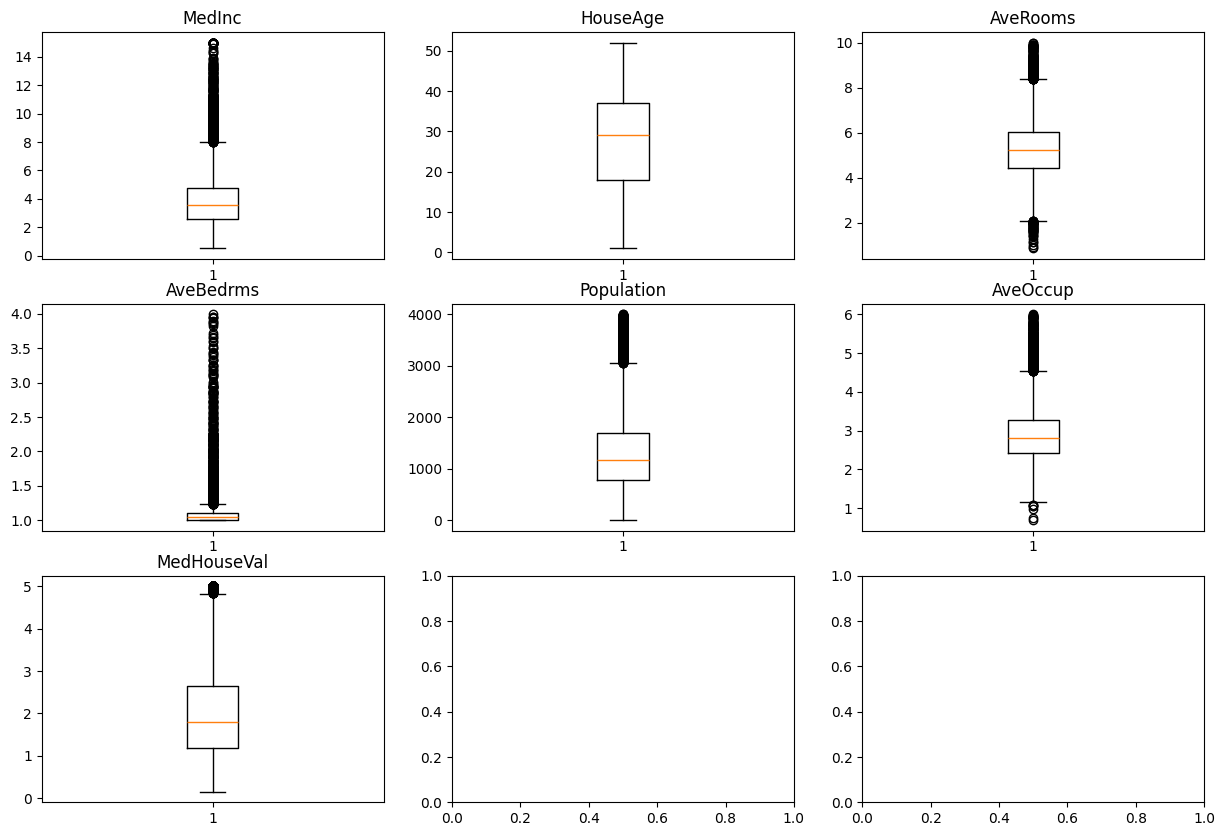

In [355]:
y = data

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))


ax[0,0].boxplot(y.iloc[:, 0])
ax[0,0].set_title("MedInc") 
        
ax[0,1].boxplot(y.iloc[:, 1])
ax[0,1].set_title("HouseAge") 

ax[0,2].boxplot(y.iloc[:, 2])
ax[0,2].set_title("AveRooms") 

ax[1,0].boxplot(y.iloc[:, 3])
ax[1,0].set_title("AveBedrms") 

ax[1,1].boxplot(y.iloc[:, 4])
ax[1,1].set_title("Population") 

ax[1,2].boxplot(y.iloc[:, 5])
ax[1,2].set_title("AveOccup") 

ax[2,0].boxplot(y.iloc[:, 8])
ax[2,0].set_title("MedHouseVal") 

plt.show()

In [356]:
data.drop(columns=["Latitude", "Longitude", "rich_area"]).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.277649,1.086730,1312.561628,2.904481,2.068558
std,1.899822,12.585558,1.224916,0.181876,745.324681,0.717309,1.153956
min,0.499900,1.000000,0.846154,1.000000,3.000000,0.692308,0.149990
25%,2.563400,18.000000,4.438304,1.006079,786.000000,2.429013,1.196000
50%,3.534800,29.000000,5.217199,1.048617,1164.000000,2.816872,1.797000
75%,4.743250,37.000000,6.013897,1.098790,1694.000000,3.275000,2.647250
max,15.000100,52.000000,10.000000,3.991501,3996.000000,6.000000,5.000010


видим как визуально все данные пришли в норму

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'MedHouseVal'}>],
       [<Axes: title={'center': 'rich_area'}>, <Axes: >, <Axes: >]],
      dtype=object)

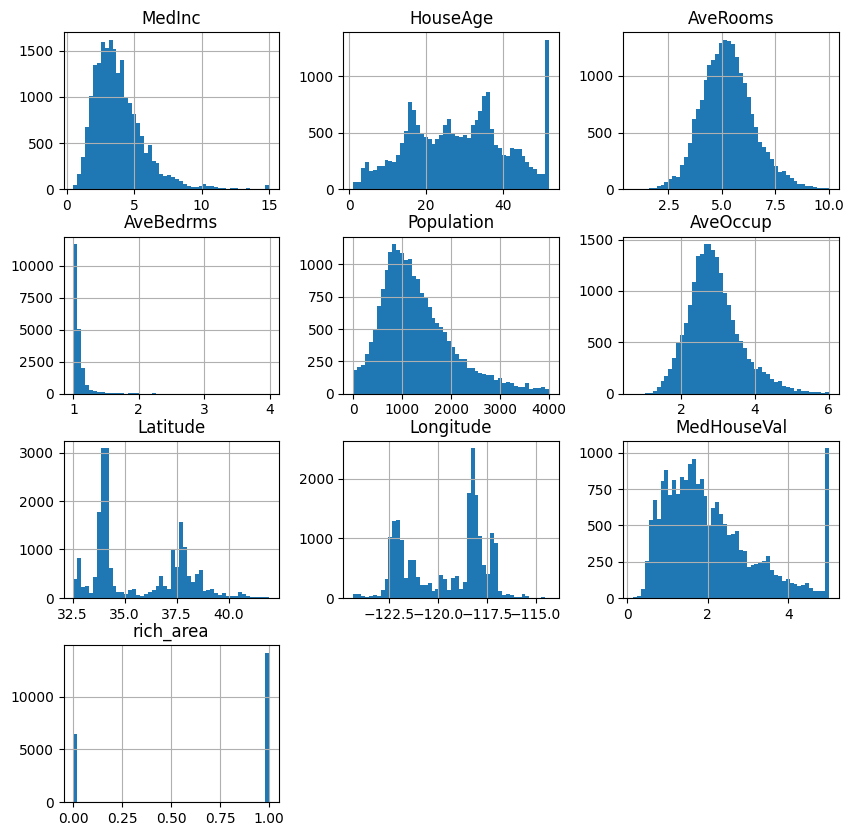

In [357]:
data.hist(bins=50, figsize=(10, 10))

#### Проверка корреляции и сравнение после работы с выбросами

сравнение корреляций

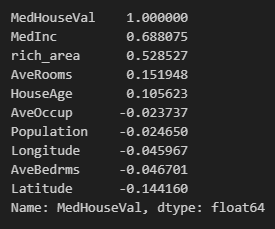

Можем заметить как увеличилась кореляция с AveRooms AveOccup

In [358]:
matrix = data.corr()
matrix['MedHouseVal'].sort_values(ascending=False)

MedHouseVal    1.000000
MedInc         0.688075
rich_area      0.528527
AveRooms       0.330162
HouseAge       0.105623
Population    -0.031481
Longitude     -0.045967
AveBedrms     -0.089182
Latitude      -0.144160
AveOccup      -0.277458
Name: MedHouseVal, dtype: float64

слишком низкая корреляция у 'Population', 'Longitude' и 'AveBedrms'.

они будут путать модель

принял решение убрать эти два признака с целью улучшение обобщающей способности и 

In [359]:
data = data.drop(['Longitude', 'Population', 'AveBedrms'], axis=1)
data

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Latitude,MedHouseVal,rich_area
0,8.3252,41.0,6.984127,1.023810,2.555556,37.88,4.526,1
1,8.3014,21.0,6.238137,1.000000,2.109842,37.86,3.585,1
2,7.2574,52.0,8.288136,1.073446,2.802260,37.85,3.521,1
3,5.6431,52.0,5.817352,1.073059,2.547945,37.85,3.413,1
4,3.8462,52.0,6.281853,1.081081,2.181467,37.85,3.422,1
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,2.560606,39.48,0.781,0
20636,2.5568,18.0,6.114035,1.315789,3.122807,39.49,0.771,0
20637,1.7000,17.0,5.205543,1.120092,2.325635,39.43,0.923,0
20638,1.8672,18.0,5.329513,1.171920,2.123209,39.43,0.847,0


RobustScaler() я выбрал по причине того, что он предназначен для работы с выбросами (outliers) в данных,

это делает его более устойчивым по сравнению с обычным масштабированием, таким как StandardScaler или MinMaxScaler.

In [360]:
scaler = RobustScaler()
scaler.fit(data.drop('MedHouseVal', axis=1))
f = ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'rich_area']
data_s = scaler.transform(data.drop('MedHouseVal', axis=1))
data_s = pd.DataFrame(data_s, columns =f, dtype = float)
data_s


,MedInc,HouseAge,AveRooms,AveOccup,Latitude,rich_area
0,2.197582,0.631579,1.121437,-0.308889,0.957672,0.0
1,2.186664,-0.421053,0.647971,-0.835745,0.952381,0.0
2,1.707732,1.210526,1.949068,-0.017272,0.949735,0.0
3,0.967177,1.210526,0.380906,-0.317885,0.949735,0.0
4,0.142854,1.210526,0.675717,-0.751081,0.949735,0.0
...,...,...,...,...,...,...
20635,-0.905796,-0.210526,-0.109003,-0.302919,1.380952,-1.0
20636,-0.448655,-0.578947,0.569206,0.361631,1.383598,-1.0
20637,-0.841709,-0.631579,-0.007398,-0.580667,1.367725,-1.0
20638,-0.765007,-0.578947,0.071284,-0.819945,1.367725,-1.0


In [361]:
data_x = data_s
data_y = data['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

# Выбор модели и оценка метрик:

        использую две метрики 

MSE - измеряет среднее значение квадратов разностей между фактическими и предсказанными значениями


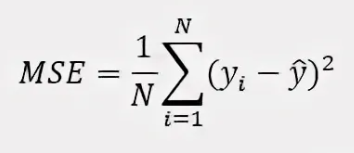

R2 - Она измеряет долю дисперсии зависимой переменной, которая может быть объяснена моделью. Коэффициент детерминации принимает значения от 0 до 1.


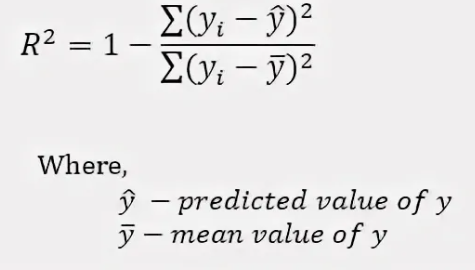

In [362]:
def metrics_table(model, X_test, y_test):
    p = model.predict(X_test)
    return pd.DataFrame({'pred':p, 'true':y_test, 'R2':r2_score(y_test, p), 'MSE':mean_squared_error(y_test, p)})

### Обучение модели
    происходит вместе с подбором гипер параметров

        n_estimators - Количество деревьев в лесу.

        max_depth - Максимальная глубина каждого дерева в лесу.

        min_samples_split - Минимальное количество объектов, необходимое для разделения внутреннего узла.

        min_samples_leaf - Минимальное количество объектов, необходимое для нахождения в листе.

        max_features - Количество признаков, которые следует учитывать при поиске наилучшего разделения.

        bootstrap - Использовать ли бутстрэп для построения деревьев.

        n_jobs - Количество параллельных работников для обучения деревьев.
        

#### для обучения я использую функцию MSE

In [363]:
param_grid = {
    'n_estimators': [100, 150, 175, 200, 225, 250],
    'max_depth': [None, 10, 20, 30, 40 ,50],
    'min_samples_split': [i+1 for i in range(10)],
    'min_samples_leaf': [i+1 for i in range(10)],  
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'n_jobs':[-1]

}

forest = RandomForestRegressor()

randomized_search = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error')

randomized_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", randomized_search.best_params_)

Лучшие гиперпараметры: {'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


Моя модель предсказывает цены на дом в среднем с точностью 78% и со средней ошибкой 28%

In [364]:
forest_best = randomized_search.best_estimator_

metrics_table(forest_best, X_test, y_test)

,pred,true,R2,MSE
20046,0.500542,0.47700,0.784951,0.281802
3024,0.785809,0.45800,0.784951,0.281802
15663,4.682599,5.00001,0.784951,0.281802
20484,2.615219,2.18600,0.784951,0.281802
9814,2.229402,2.78000,0.784951,0.281802
...,...,...,...,...
15362,2.531781,2.63300,0.784951,0.281802
16623,2.156083,2.66800,0.784951,0.281802
18086,4.930804,5.00001,0.784951,0.281802
2144,0.743245,0.72300,0.784951,0.281802


# Интерпретация результатов и выводы:

На модель очень сильно влияет зарплата человека, расположение, количество комнат, возраст дома.


Но стоит заметить, что широта не всегда хорошо может дать понимание где находится богатые дома, а где бедные. Могу предположить, что мы можем от неё избавиться путём создания сетки богатых районов, и присваивать каждому блоку значение богатый он или нет, в каждом квадрате считать среднию цену дома на квадрат. Я сделал что то похожее, но оно выделяет очень грубо и плохо разделяет богатые районы от бедных.

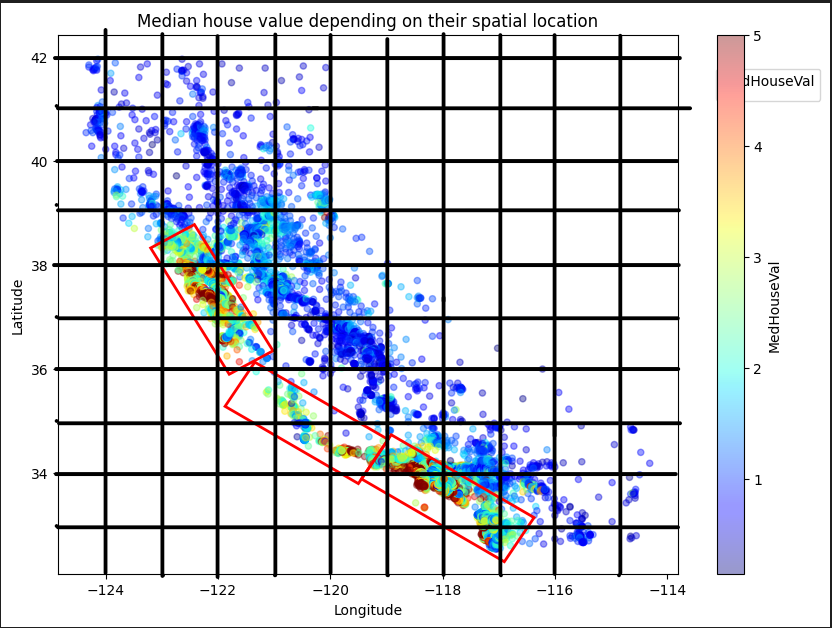

это бы дало наибольшую точность и исключило бы переобучения модели.